# Intermittent Cointegration Inference

## Python notebook implementation

The code in this notebook is adapted from the original MATLAB implementation by Chris Bracegirdle for the paper [*Bayesian Conditional Cointegration*](http://icml.cc/2012/papers/570.pdf) presented at [*ICML 2012*](http://icml.cc/2012/).

<a class="typeform-share button" href="https://bayesiancointegration.typeform.com/to/gRS0pq" data-mode="popup" style="display:inline-block;text-decoration:none;background-color:#267DDD;color:white;cursor:pointer;font-family:Helvetica,Arial,sans-serif;font-size:20px;line-height:50px;text-align:center;margin:0;height:50px;padding:0px 33px;border-radius:25px;max-width:100%;white-space:nowrap;overflow:hidden;text-overflow:ellipsis;font-weight:bold;-webkit-font-smoothing:antialiased;-moz-osx-font-smoothing:grayscale;" target="_blank">Contact me</a><script>(function(){var qs,js,q,s,d=document,gi=d.getElementById,ce=d.createElement,gt=d.getElementsByTagName,id="typef_orm_share",b="https://s3-eu-west-1.amazonaws.com/share.typeform.com/";if(!gi.call(d,id)){js=ce.call(d,"script");js.id=id;js.src=b+"share.js";q=gt.call(d,"script")[0];q.parentNode.insertBefore(js,q)}})()</script>

In [1]:
from numpy import sum, polyfit, inf, array, isreal, zeros, ones, insert, append, tile, concatenate, atleast_2d
from scipy import log, sqrt, exp, std
from scipy.misc import logsumexp
from scipy.stats import norm 

""" Bayesian Intermittent Cointegration 
Implementation of inference for intermittent cointegration

Written by Chris Bracegirdle
(c) Chris Bracegirdle 2015. All rights reserved."""

' Bayesian Intermittent Cointegration \nImplementation of inference for intermittent cointegration\n\nWritten by Chris Bracegirdle\n(c) Chris Bracegirdle 2015. All rights reserved.'

Some notebook-specific requirements here: we're going to show some plots, so provide a helper function for formatting a live updating the charts in the notebook.

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib notebook
xtickfmt = mdates.DateFormatter('%b %Y')
def pltsin(ax, x, y, line_number=0, update_x=False):
    if ax.lines and len(ax.lines)>line_number:
        line = ax.lines[line_number]
        if update_x: line.set_xdata(x)
        line.set_ydata(y)
    else:
        ax.plot(x,y)
    ax.relim()
    ax.autoscale_view()
    ax.get_figure().canvas.draw()
    plt.show()

The following functions are copied almost exactly from the standard Bayesian Cointegration code except are updated to support vector notation for speed purposes. Numpy works much more quickly with vector functions than looping over array elements!

In [3]:
def LinearRegression(x,y):
    slope, intercept = polyfit(x, y, 1)
    std_eta = std( y - intercept - slope * x , ddof=1 )
    return slope, intercept, std_eta

In [4]:
def ParCointInference(epsilon,std_eta,pitgitm1,pi2):
    logalpha,loglik,fstats = Filtering(epsilon,std_eta,pitgitm1,pi2)
    loggamma,moment1,moment2 = Smoothing(pitgitm1,logalpha,fstats)
    return logalpha,loglik,loggamma,moment1,moment2

In [5]:
def vCalcLogAreaLog(logf,logF):
    logf = array(logf); logF = array(logF)
    my_ones = tile([1,-1], logf.shape+(1,)).T
    lncdf = norm.logcdf(my_ones, loc=exp(logf).real, scale=exp(0.5*array(logF)).real)
    logarea = logsumexp(lncdf,b=my_ones,axis=0)-log(2)
    return logarea

def vCalcLogMomentsLog(logf,logF,logarea):
    logf = array(logf); logF = array(logF)
    lnpdfplogFmlogarea = norm.logpdf(tile([1,-1], logf.shape+(1,)).T, loc=exp(logf).real, scale=exp(0.5*logF).real) + logF - logarea
    logmoment1 = logsumexp(concatenate([lnpdfplogFmlogarea, [logf]]),b=tile([-0.5, 0.5, 1], logf.shape+(1,)).T,axis=0)
    logmoment2 = logsumexp(concatenate([logf+lnpdfplogFmlogarea, lnpdfplogFmlogarea, [2*logf], [logF]]),
                           b=tile([-0.5, 0.5, -0.5, -0.5, 1, 1], logf.shape+(1,)).T,axis=0).real
    return logmoment1,logmoment2

A function that imports the relevant source data of gas prices. For reference, see the paper.

<IPython.core.display.Javascript object>


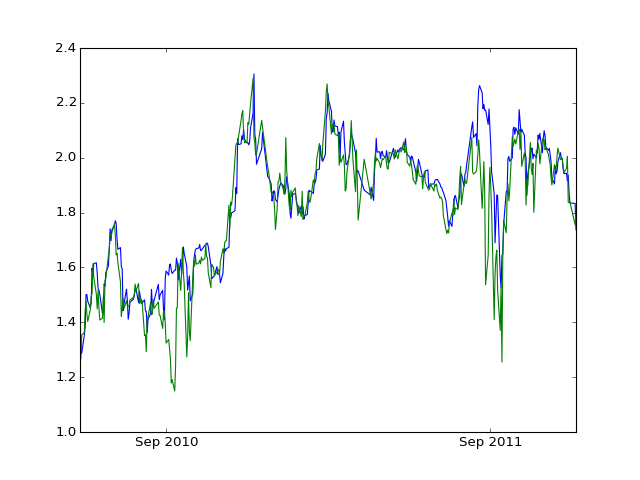

In [6]:
def LoadGasData():
    from pandas import read_csv
    df = read_csv('data/pd-sap-zee.csv',delimiter=',', header=0, parse_dates=[0])
    dates = df['date']
    x = df['ZEE'].as_matrix()
    y = df['SAP'].as_matrix()
    return x,y,dates
    
x,y,dates = LoadGasData()
fig = plt.figure("Gas source data")
plt.plot(dates,x,dates,y)
xticks = fig.axes[0].lines[0].get_xdata()[[70, 320]]
fig.axes[0].set_xticks(xticks); fig.axes[0].xaxis.set_major_formatter(xtickfmt)

OK, here we go with the main filtering and smoothing routines. Note that while these functions scale quadratically, there is only one loop since we are using numpy's powerful vectorised functions.

In [7]:
def Filtering(V,std_eta,pitgitm1,pi2):

    # initialise
    T = len(V); logV = log(V)
    logpitgitm1 = log(pitgitm1)
    logalpha = zeros([T,2])
    fstats = {'logareaw': -inf*ones([T,T-1]),
              'logmoment1w': -inf*ones([T,T-1], dtype=complex),
              'logmoment2w': -inf*ones([T,T-1])}
   
    # first time-step (t=1)
    t = 1; loglik = 0
    
    # prepare p( i_{t+1} | i_t )
    logpitp1git = zeros([2,2])
    logpitp1git[0,:] = log(pi2[0]); logpitp1git[1,:] = log(pi2[1])
    
    # remaining time-steps:
    lnpdfs = norm.logpdf(V[t:], loc=V[:-1], scale=std_eta)

    for t in range(1,T):
        logft = zeros(t, dtype=complex); logFt = zeros(t); logwt = zeros(t)

        # it=1
        logZ10 = lnpdfs[t-1] + logpitp1git[1,0]
        logZ11 = lnpdfs[t-1] + logpitp1git[1,1]

        # it=0  --- the interesting case!
        
        # new component
        logft[0] = logV[t] - logV[t-1]
        logFt[0] = (2*log(std_eta) - 2*logV[t-1]).real
        logwt[0] = logpitp1git[0,1] - log(abs(V[t-1]))
    
        # existing components
        if t > 1:
            bottomparts = logsumexp(concatenate([tile(2*log(std_eta), (t-1,1)), 2*logV[t-1] + atleast_2d(logFtm1).T],
                                                axis = 1), 
                                    axis = 1).real
            logft[1:] = logsumexp([logftm1 + 2*log(std_eta), logFtm1 + logV[t] + logV[t-1]], axis = 0) - bottomparts
            logFt[1:] = (2*log(std_eta) + logFtm1 - bottomparts).real
            logwt[1:] = logpitp1git[0,0] + logwtm1 + norm.logpdf(V[t], loc=exp(logV[t-1] + logftm1).real, 
                                                                       scale=exp(0.5 * bottomparts))

        logarea = vCalcLogAreaLog(logft,logFt)
        logmoment1, logmoment2 = vCalcLogMomentsLog(logft,logFt,logarea)
        logZ01 = logwt[0] + logarea[0]

        if t == 1:
            logZ00prefactor = logpitp1git[0,0] - log(abs(V[t-1]))
            logwt[0] = logsumexp([logwt[0], logZ00prefactor])
            logZ00 = logZ00prefactor + logarea[0]
        else:
            logZ00 = logsumexp(logwt[1:] + logarea[1:])
        
        logZ0 = logsumexp([logZ00, logZ01]); logZ1 = logsumexp([logZ10, logZ11])
        logZ = logsumexp([logZ00, logZ01, logZ10, logZ11])
        logalpha[t,0] = logZ0 - logZ; logalpha[t,1] = logZ1 - logZ

        logwt = logwt - logZ0
        assert logwt[0]!=0
        
        # store stats times w
        fstats['logareaw'][t,0:t] = logarea[:t] + logwt
        fstats['logmoment1w'][t,0:t] = logmoment1[:t] + logwt + logarea
        fstats['logmoment2w'][t,0:t] = logmoment2[:t] + logwt + logarea
        
        loglik = (loglik + logZ).real
        
        # update registers
        logftm1 = logft; logFtm1 = logFt; logwtm1 = logwt

        # prepare p( i_{t+1} | i_t )
        logpitp1git[0,:] = logpitgitm1[0,:] + logalpha[t,:]
        logpitp1git[1,:] = logpitgitm1[1,:] + logalpha[t,:]

    return logalpha,loglik,fstats

In [8]:
def Smoothing(pitgitm1,logalpha,fstats):
    # initialise
    T = len(logalpha)
    logpitgitm1 = log(pitgitm1)
    
    # time t=T
    loggamma = zeros([T,2])
    loggamma[-1,:] = logalpha[-1,:]
  
    # calculate first and second moments for EM
    logmoment1 = zeros(T, dtype=complex); logmoment2 = zeros(T)
    logmoment1[-1] = logsumexp(append(logalpha[-1,0]+fstats['logmoment1w'][-1,:],logalpha[-1,1]))
    logmoment2[-1] = logsumexp(append(logalpha[-1,0]+fstats['logmoment2w'][-1,:],logalpha[-1,1]))
    
    # t<T
    logprefactors1 = zeros(0)
    lses = logsumexp(logpitgitm1[1,:] + logalpha, axis=1)
    for t in reversed(range(T-1)):

        logintegralprefactor = logalpha[-1,0] + fstats['logareaw'][-1,-t-1] # the component from T
        if t > 0: # components from T
            logmoment1T = logalpha[-1,0] + logsumexp(fstats['logmoment1w'][-1,-t:])
            logmoment2T = logalpha[-1,0] + logsumexp(fstats['logmoment2w'][-1,-t:])
        else:
            logmoment1T = -inf
            logmoment2T = -inf

        # components from t:T-1        
        logprefactors1 = insert(logprefactors1,0,loggamma[t+1,1] + logpitgitm1[1,0] + logalpha[t,0] - lses[t])

        ftsatslogareaws = fstats['logareaw'][range(t+1,T-1),range(T-t-2)]
        logintegralparts = logprefactors1[1:] + ftsatslogareaws
        
        diagonals = tile(range(t,T-1),(t,1)).T,[range(s,t+s) for s in range(T-t-1)]
        logmoment1parts = (logprefactors1 + logsumexp(fstats['logmoment1w'][diagonals], axis=1)) if t else []
        logmoment2parts = (logprefactors1 + logsumexp(fstats['logmoment2w'][diagonals], axis=1)) if t else []
        
        loggamma[t,1] = logsumexp(concatenate([[logintegralprefactor], logintegralparts,
                                   [loggamma[t+1,1] + logpitgitm1[1,1] + logalpha[t,1]
                                     - logsumexp(logpitgitm1[1,:] + logalpha[t,:])]]))

        if t > 0:
            logmoment1[t] = logsumexp(concatenate([[logmoment1T], logmoment1parts, [loggamma[t,1]]]))
            logmoment2[t] = logsumexp(concatenate([[logmoment2T], logmoment2parts, [loggamma[t,1]]]))
    
    gamma = zeros([T,2])
    gamma[:,1] = exp(loggamma[:,1])
    gamma[:,0] = 1 - gamma[:,1]
    loggamma[:,0] = log(gamma[:,0])
    moment1 = exp(logmoment1).real
    moment2 = exp(logmoment2).real
    
    return loggamma,moment1,moment2

Now the update of the model parameters

In [9]:
def EMUpdate(x,y,moment1,moment2):
    T = x.size
    xt, xtm1 = x[1:], x[:-1]
    yt, ytm1 = y[1:], y[:-1]
    
    # find the coefficients
    a = 2 * sum(moment1[1:]) - sum(moment2[1:]) - (T-1)
    b = sum(moment1[1:] * (xt + xtm1)) - sum(moment2[1:] * xtm1) - sum(xt)
    c = sum(moment2[1:] * ytm1) - sum(moment1[1:] * (yt + ytm1)) + sum(yt)
    d = 2 * sum(moment1[1:] * xt * xtm1) - sum(moment2[1:] * (xtm1 ** 2)) - sum(xt ** 2)
    e = sum(moment2[1:] * xtm1 * ytm1) - sum(moment1[1:] * (xtm1 * yt + xt * ytm1)) + sum(xt * yt)
        
    # solve simultaneous equations
    slope = ((a * e) - (c * b)) / ((b ** 2) - (a * d))
    intercept = (-slope * d / b) - (e / b)

    # now find optimal sigma
    eps = y - intercept - slope * x
    ept, eptm1 = eps[1:], eps[:T-1]
    std_eta = sqrt( (sum(ept**2) - 2 * sum(moment1[1:] * ept * eptm1) + sum(moment2[1:] * eptm1 ** 2)) / (T-1) )

    assert std_eta>0,"Standard deviation must be positive"
    assert isreal(std_eta),"Standard deviation must be real"
    return slope,intercept,std_eta

Finally, the below cell runs the full inference process over the source data. There should be six iterations and execution takes a minute or two, depending on your processor speed. Just be patient and watch the plots update live!

<IPython.core.display.Javascript object>


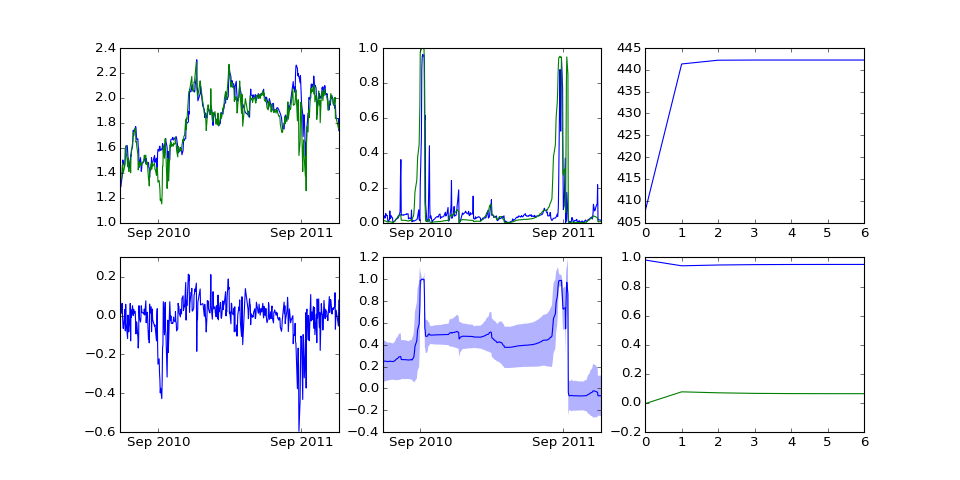

slope,intercept,std_eta
0.952118070187 0.0632855162392 0.0730737446967


In [10]:
x,y,dates = LoadGasData()

pi2 = zeros([2,1])
pi2[0]=0.95; pi2[1]=1-pi2[0]

pitgitm1 = zeros([2,2])
pitgitm1[0,0]=1-1.0/230
pitgitm1[0,1]=1.0/15
pitgitm1[1,:]=1-pitgitm1[0,:]

slope,interc,std_eta = LinearRegression(x,y)

slopes=[]; intercs=[]; std_etas=[]; logliks = [-inf]

fig, ax = plt.subplots(2,3,figsize=(12, 6), num="Intermittent Cointegration Inference: Gas")
map(lambda myax: myax.xaxis.set_major_formatter(xtickfmt), ax[0:1,0:1].flatten()); 
ax[0,0].plot(dates,x,dates,y); ax[0,0].set_xticks(xticks)
plt.show()
for i in range(1000):
    slopes.append(slope)
    intercs.append(interc)
    std_etas.append(std_eta)

    pltsin(ax[1,2],range(i+1),slopes,update_x=True); pltsin(ax[1,2],range(i+1),intercs,1,update_x=True)

    # calculate epsilon
    epsilon=y-interc-slope*x;
    pltsin(ax[1,0],dates,epsilon); ax[1,0].set_xticks(xticks)

    logalpha,loglik,loggamma,moment1,moment2 = ParCointInference(epsilon,std_eta,pitgitm1,pi2)

    alpha = exp(logalpha).real
    logliks.append(loglik)
    pltsin(ax[0,2],range(i+1),logliks[1:],update_x=True)

    # plot cointegration filtered posterior
    pltsin(ax[0,1],dates[1:],alpha[1:,1]); ax[0,1].set_xticks(xticks)

    gamma = exp(loggamma).real

    pltsin(ax[0,1],dates[1:],gamma[1:,1],1)

    # plot moment1 with error
    ax[1,1].clear(); pltsin(ax[1,1],dates[1:],moment1[1:]); ax[1,1].set_xticks(xticks)
    ax[1,1].fill_between(ax[1,1].lines[0].get_xdata(), moment1[1:]-sqrt(moment2[1:]-moment1[1:]**2), 
                                                       moment1[1:]+sqrt(moment2[1:]-moment1[1:]**2), 
                                                       facecolor='blue', alpha=0.3, linewidth=0)

    slope,interc,std_eta = EMUpdate(x,y,moment1,moment2)

    if logliks[-1]-logliks[-2]<0.0001: break

print "slope,intercept,std_eta"
print slope,interc,std_eta

And there we have it. Clockwise, the plots show:
- source data
- filtered (blue) and smoothed (green) posterior of class
- log likelihood of the model fit
- slope (blue) and intercept (green) estimate iterations
- first moment of $\phi$ with error
- residuals of latest fit

<a class="typeform-share button" href="https://bayesiancointegration.typeform.com/to/gRS0pq" data-mode="popup" style="display:inline-block;text-decoration:none;background-color:#267DDD;color:white;cursor:pointer;font-family:Helvetica,Arial,sans-serif;font-size:20px;line-height:50px;text-align:center;margin:0;height:50px;padding:0px 33px;border-radius:25px;max-width:100%;white-space:nowrap;overflow:hidden;text-overflow:ellipsis;font-weight:bold;-webkit-font-smoothing:antialiased;-moz-osx-font-smoothing:grayscale;" target="_blank">Contact me</a><script>(function(){var qs,js,q,s,d=document,gi=d.getElementById,ce=d.createElement,gt=d.getElementsByTagName,id="typef_orm_share",b="https://s3-eu-west-1.amazonaws.com/share.typeform.com/";if(!gi.call(d,id)){js=ce.call(d,"script");js.id=id;js.src=b+"share.js";q=gt.call(d,"script")[0];q.parentNode.insertBefore(js,q)}})()</script>